# Interpretability

- Data load and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error

In [2]:
#de mateo
#de mateo
#de mateo
dfFeature = pd.read_csv(r'pruebaData.csv')
dfFeature.drop(columns=['Complain'], inplace= True)

X = dfFeature.drop('Exited', axis=1)
y = dfFeature['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

INTRINSICALLY INTERPRETABLE MODELS:

First, we are going to analyze the interpretability of some classification models we have used, which are Logistic Regression and Decision Trees. The objective is to determine which of the variables have more impact in the outcome 

- Logistic Regression

In [3]:
#de mateo
#de mateo
#de mateo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga","sag"])
    C = trial.suggest_float("C", 1e-6, 1e2, log =True)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=42,
        class_weight='balanced',
        max_iter= max_iter
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=500, n_jobs=-1)
print("Best hyperparameters:", study.best_params)

[I 2024-12-22 11:43:31,202] A new study created in memory with name: no-name-883380d9-857a-4ac6-939c-17708c2e9bb2


[I 2024-12-22 11:43:36,533] Trial 3 finished with value: 0.7961172482206663 and parameters: {'solver': 'liblinear', 'C': 0.06474099944263524, 'max_iter': 1740}. Best is trial 3 with value: 0.7961172482206663.
[I 2024-12-22 11:43:36,631] Trial 5 finished with value: 0.7961090618408762 and parameters: {'solver': 'lbfgs', 'C': 20.03392215721631, 'max_iter': 950}. Best is trial 3 with value: 0.7961172482206663.
[I 2024-12-22 11:43:36,644] Trial 0 finished with value: 0.7961042463233523 and parameters: {'solver': 'lbfgs', 'C': 0.11984915312937632, 'max_iter': 2193}. Best is trial 3 with value: 0.7961172482206663.
[I 2024-12-22 11:43:36,688] Trial 11 finished with value: 0.7961032832198477 and parameters: {'solver': 'saga', 'C': 40.74661570805942, 'max_iter': 1230}. Best is trial 3 with value: 0.7961172482206663.
[I 2024-12-22 11:43:36,709] Trial 10 finished with value: 0.7961206190829329 and parameters: {'solver': 'lbfgs', 'C': 0.010860260149336581, 'max_iter': 4599}. Best is trial 10 with 

Best hyperparameters: {'solver': 'sag', 'C': 0.04579183842769677, 'max_iter': 2878}


In [5]:
best_params = study.best_params
logistic_model = LogisticRegression(
    solver=best_params["solver"],
    C=best_params["C"],
    random_state=42,
    class_weight='balanced',
    max_iter=best_params["max_iter"]
)

logistic_model.fit(X_train_scaled, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logistic_score = cross_val_score(logistic_model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(logistic_score)

0.7961427704635418


In [6]:
coefs_log = logistic_model.coef_
intercept_log = logistic_model.intercept_
print('coefficients: %s' % coefs_log)
print('intercept: %s' % intercept_log)

coefficients: [[-0.07078946 -0.01183164  0.07116529 -0.4279647  -0.01854402 -0.41129686
   0.03858992 -0.01581162 -0.05136083  0.14378692 -0.14378692 -0.14631431
   0.26160796 -0.09329638  0.03101078 -0.02271122 -0.00614268 -0.00191312
  -0.29959263  0.26894388  0.47822817 -0.37389046  0.15469947]]
intercept: [-0.3790839]


In [7]:
# Feature Importance
coef_df = pd.DataFrame({'feature': X_train.columns.values, 'coef': coefs_log[0]})
coef_df

,feature,coef
0,CreditScore,-0.070789
1,Tenure,-0.011832
2,Balance,0.071165
3,NumOfProducts,-0.427965
4,HasCrCard,-0.018544
5,IsActiveMember,-0.411297
6,EstimatedSalary,0.038590
7,Satisfaction Score,-0.015812
8,Point Earned,-0.051361
9,Gender_Female,0.143787


In [8]:
#Standardized
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(23,) * stdv).sort_values(ascending=False)

Balance               4433.903166
EstimatedSalary       2216.029517
Point Earned            11.610696
CreditScore              6.844637
NumOfProducts            0.213953
IsActiveMember           0.205535
Age_30-40                0.148598
Age_<30                  0.138739
Age_50-60                0.134869
Age_40-50                0.117579
Geography_Germany        0.113468
Geography_France         0.073157
Gender_Female            0.071553
Gender_Male              0.071553
Geography_Spain          0.040311
Age_>60                  0.034888
Tenure                   0.034197
Satisfaction Score       0.022299
Card Type_DIAMOND        0.013381
Card Type_GOLD           0.009896
HasCrCard                0.008436
Card Type_PLATINUM       0.002659
Card Type_SILVER         0.000826
dtype: float64

- Decision Tree

In [9]:
#de mateo
#de mateo
#de mateo
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight="balanced", 
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_params)

[I 2024-12-22 11:44:43,746] A new study created in memory with name: no-name-5ac7a1f4-edd3-4dd7-a4f5-b1d90394b4ce
[I 2024-12-22 11:44:44,139] Trial 0 finished with value: 0.7690087738729281 and parameters: {'n_estimators': 888, 'max_depth': 47, 'min_samples_split': 26, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 0 with value: 0.7690087738729281.
[I 2024-12-22 11:44:44,376] Trial 2 finished with value: 0.7733540561104102 and parameters: {'n_estimators': 692, 'max_depth': 30, 'min_samples_split': 30, 'min_samples_leaf': 26, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7733540561104102.
[I 2024-12-22 11:44:44,463] Trial 5 finished with value: 0.6885034334639943 and parameters: {'n_estimators': 596, 'max_depth': 50, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.7733540561104102.
[I 2024-12-22 11:44:44,518] Trial 3 finished with value: 0.7364019416166656 and parameters: {'n_estimators': 879, 'max_depth': 40, '

Best hyperparameters: {'n_estimators': 148, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 28, 'max_features': None}


In [10]:
best_params = study.best_params
decision_tree = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    class_weight="balanced",
)
decision_tree.fit(X_train, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
decision_score = cross_val_score(decision_tree, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(decision_score)

0.7915018154501064


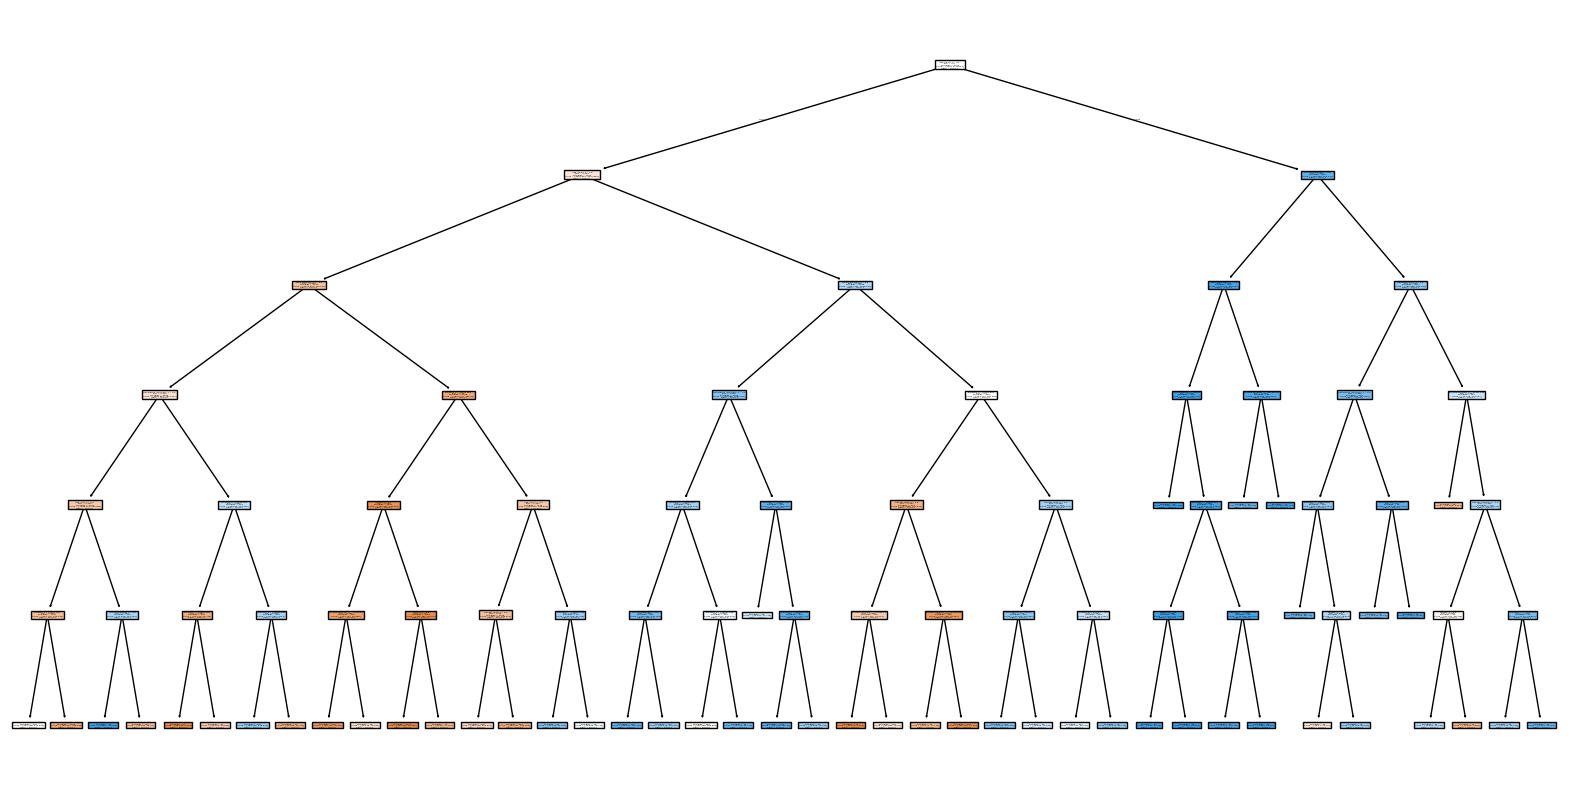

In [11]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'])
plt.show()

In [12]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),
'importance': decision_tree.feature_importances_}).sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
20,Age_50-60,0.229698
19,Age_40-50,0.210778
2,Balance,0.205017
3,NumOfProducts,0.119343
5,IsActiveMember,0.067113
12,Geography_Germany,0.064612
22,Age_>60,0.046230
6,EstimatedSalary,0.019444
10,Gender_Male,0.015791
1,Tenure,0.012211


Now we will interprate the results given by both models:

    Logistic Regression:

 -Most possitively influential variables:  'Age_50-60' (0.47), 'Age_40-50' (0.26) and 'Geography_Germany' (0.26)

 -Most negatively influential variables: NumOfProducts (-0.42), 'IsActiveMember'(-0.41) and 'Age_<30' (-0.37)

 -Most influential standardized variables: 'Balance' (4435.93) and 'EstimatedSalary' (2214.62)

The logistic regression model (79.61%) indicates that age and geography, as well as the balance and the estimated salary are really important for the model's predictions.

We can see that age categories follow a clear pattern, the old customers with higher balance, have the highest chance to exit on the outcome, while the young and inactive customer is the least likely to exit.

Also, If we compare 'Gender_Female' (0.14) and 'Gender_Male' (-0.14), we can se that male customers have a negative influence and females are possitively influential in this case, showing that females are more likely to exit and males to stay. Also, German people seem to be specially predisposed to exiting banks. 

The negative intercept (-0.37) means that if there is no influence, customers are less likely to exit. But this is not relevant in out case because variables like age are practically never 0.

    Decision Tree

The decision tree model (78.91%) suggests that it's most important features are 'Age_50-60' (0.22), 'Balance' (0.19), 'Age_40-50' (0.19) and 'NumOfProducts' (0.10). The rest have low or 0 relevance. In conclussion, the decision tree model supports our logistic regression model's conclussions which are the most important factors.

GLOBAL MODEL AGNOSTIC METHODS

The second step is to understand which is the way our models work, for that we are going to use PDP and ALE:

- Partial Dependence Plot (PDP)

For this section, we are going to apply PDP to the most influential variables of the decision tree model

Text(0.5, 0.98, 'Partial Dependence Plots - Decision Tree')

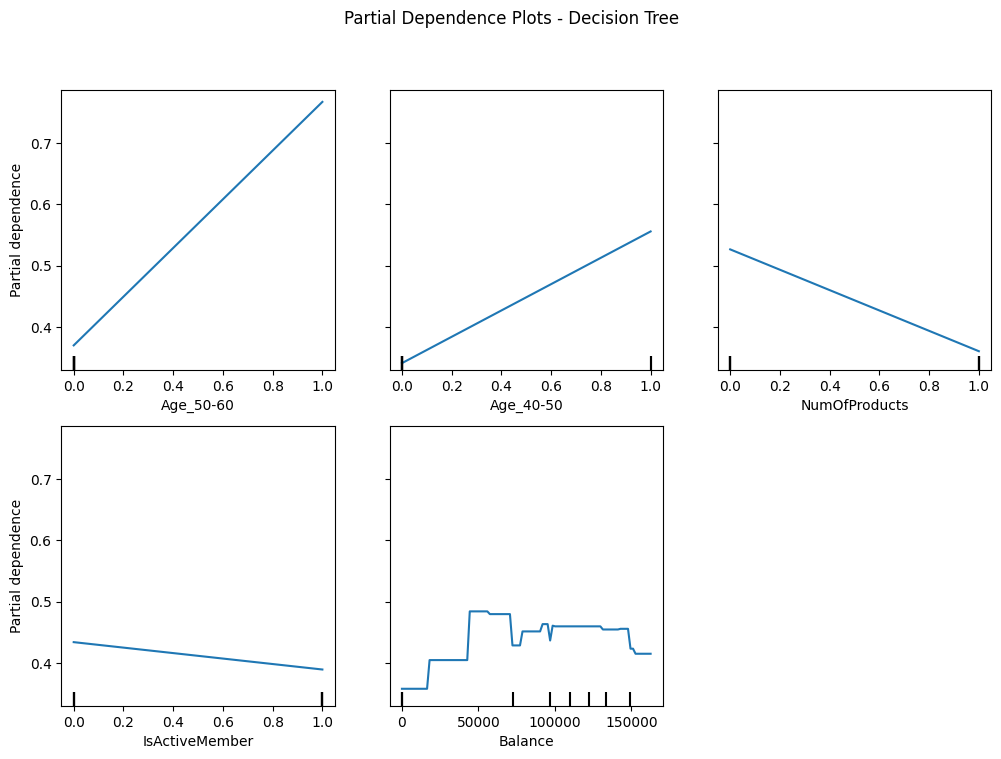

In [13]:
features = ["Age_50-60", "Age_40-50","NumOfProducts", "IsActiveMember", "Balance"]

fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(decision_tree, X_train, features, kind="average", ax=ax)
display.figure_.suptitle("Partial Dependence Plots - Decision Tree")

- Accumulated Local Effects (ALE)

In [89]:
from alibi.explainers import ALE, plot_ale
#problemas con la libreria alibi, no es compatible con numpy, y desconfigura otras librerias
features = ["Age_50-60", "Age_40-50","NumOfProducts", "IsActiveMember", "Balance"]

logisticALE = ALE(logistic_model.predict, feature_names=features)
decisionTreeALE = ALE(decision_tree.predict, feature_names=features)

logisticExp = logisticALE.explain(X_train)
decisionTreeExp = decisionTreeALE.explain(X_train)

# Plot ALEs
plot_ale(decisionTreeExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 7})
logisticMSE = mean_squared_error(y_test, logistic_model.predict(X_test))
print(f"Logistic Regression MSE: {logisticMSE}")

ImportError: cannot import name 'ALEExplainer' from 'interpret.ext.blackbox' (c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\interpret\ext\blackbox\__init__.py)

In [ ]:
plot_ale(decisionTreeExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 7})
decisionTreeMSE = mean_squared_error(y_test, decision_tree.predict(X_test))
print(f"Random Forest MSE: {decisionTreeMSE}")

    PDP

The result suggests that firstly, for both 'Age_50-60' and 'Age_40-50', as the value increases (it can only be 0 or 1), the chances of exit prediction also increases, although its less pronounced for the 40-50 age varaible, the effects is really similar. Also, it seems like the 'NumOfProducts' variable has almost the contrary effect on the model if we compare it with 'Age_40-50', and much the same happens with 'isActiveMember', but less strongly.  

Secondly, the relation between the 'Balance' variable's value, and the changes of exit prediction change, not as in the previous case. So, as well as we know that this variable is really important for the model's predictions, now we know that the way this variable is considered for the model's prediction is not linear, as we could have guessed → (Higher balance → + chances of exit).

    ALE

In this case,

Overall, we can see that PDP supports the conclussions we have made for the 'intrinsically interpretable model' step's results, but also, giving some really interesting insights, on how each of the most important variables in the model affect the prediction.

